Dimer with Kanamori interaction
=======

We calculate the Green function of a dimer coupled with Kanamori interaction and a coupling to discrete bath states.

The non-interacting hamiltonian is most conveniently expressed using a matrix representation

$$
\hat{h} =
\begin{pmatrix}
\hat{h}_{0} & \hat{h}_{\rm coup} \\
\hat{h}_{\rm coup} & \hat{h}_{\rm bath}  \\
\end{pmatrix}=
\begin{pmatrix}
\begin{pmatrix}
\epsilon_0 -\mu & -t \\
-t & \epsilon_1 -\mu
\end{pmatrix} & 
\begin{pmatrix}
1 & 0 \\
0 & 1
\end{pmatrix}
\\
\begin{pmatrix}
1 & 0 \\
0 & 1
\end{pmatrix} & 
\begin{pmatrix}
\epsilon_{0,{\rm bath}} & -t_{\rm bath} \\
-t_{\rm bath} & \epsilon_{1,{\rm bath}}
\end{pmatrix}
\end{pmatrix}
$$

The impurity interaction is of the Kanamori-type, and reads

$$h_{\rm int} = \sum_{i,j} U n_{\uparrow,i} n_{\downarrow,j} + \sum_{\sigma,i\neq j} U' n_{\sigma,i} n_{\sigma,j}
            - \sum_{i \neq j} J c^\dagger_{i \uparrow} c_{i \downarrow} c^\dagger_{j \downarrow} c_{j \uparrow}
            + \sum_{i \neq j} J c^\dagger_{i \uparrow} c^\dagger_{i \downarrow} c_{j \downarrow} c_{j \uparrow}$$
   
The parameters are defined below.

In [24]:
# %load model.py
import sys, os
sys.path.append(os.getcwd() + '/../common')
from util import *

from triqs.gf import Gf, MeshImFreq, iOmega_n, inverse
from triqs.operators import c, c_dag, n
from triqs.operators.util import h_int_kanamori, U_matrix_kanamori
from itertools import product
from numpy import matrix, array, block, diag, eye, exp, dot
from numpy.linalg import inv

# ==== System Parameters ====
beta = 5.                       # Inverse temperature
mu = 0.0                        # Chemical potential
eps = array([0.0, 0.1])         # Impurity site energies
t = 0.0                         # Hopping between impurity sites

eps_bath = array([0.27, -0.4])  # Bath site energies
t_bath = 0.0                    # Hopping between bath sites

U = 1.                          # Density-density interaction
J = 0.2                         # Hunds coupling

block_names = ['up', 'dn']
n_orb = len(eps)
n_orb_bath = len(eps_bath)

# Non-interacting impurity Hamiltonian in matrix representation
h_0_mat = diag(eps - mu) - matrix([[0, t],
                                   [t, 0]])

# Bath Hamiltonian in matrix representation
h_bath_mat = diag(eps_bath) - matrix([[0, t_bath],
                                      [t_bath, 0]])

# Coupling matrix
V_mat = matrix([[1., 0.],
                [0., 1.]])

# ==== Local Hamiltonian ====
c_dag_vec = { s: matrix([[c_dag(s,o) for o in range(n_orb)]]) for s in block_names }
c_vec =     { s: matrix([[c(s,o)] for o in range(n_orb)]) for s in block_names }

h_0 = sum(c_dag_vec[s] * h_0_mat * c_vec[s] for s in block_names)[0,0]

Umat, Upmat = U_matrix_kanamori(n_orb, U_int=U, J_hund=J)
h_int = h_int_kanamori(block_names, range(n_orb), Umat, Upmat, J, off_diag=True)

h_imp = h_0 + h_int

# ==== Bath & Coupling Hamiltonian ====
c_dag_bath_vec = { s: matrix([[c_dag(s, o) for o in range(n_orb, n_orb + n_orb_bath)]]) for s in block_names }
c_bath_vec =     { s: matrix([[c(s, o)] for o in range(n_orb, n_orb + n_orb_bath)]) for s in block_names }

h_bath = sum(c_dag_bath_vec[s] * h_bath_mat * c_bath_vec[s] for s in block_names)[0,0]
h_coup = sum(c_dag_vec[s] * V_mat * c_bath_vec[s] + c_dag_bath_vec[s] * V_mat.H * c_vec[s] for s in block_names)[0,0]

# ==== Total impurity Hamiltonian ====
h_tot = h_imp + h_coup + h_bath

# ==== Green function structure ====
gf_struct = [ (s, n_orb) for s in block_names ]

# ==== Hybridization Function ====
n_iw = int(10 * beta)
n_tau = 10001
tau_mesh = MeshImTime(beta, 'Fermion', n_tau)
Delta_tau = BlockGf(mesh=tau_mesh, gf_struct=gf_struct)

def one_fermion(tau, eps, beta):
    if (eps >= 0):
        return -exp(-tau * eps) / (1. + exp(-beta * eps))
    else:
        return -exp((beta - tau) * eps) / (1. + exp(beta * eps))

for bl, tau, i, j in product(["up", "dn"], tau_mesh, range(n_orb), range(n_orb)):
    Delta_tau[bl][tau][i,j] = sum(V_mat[i,k] * one_fermion(tau.value, eps=eps_bath[k], beta=beta) * V_mat.H[k,j] for k in range(n_orb_bath))


Results
======

In [25]:
from triqs.plot.mpl_interface import oplot, plt
%matplotlib inline

10001


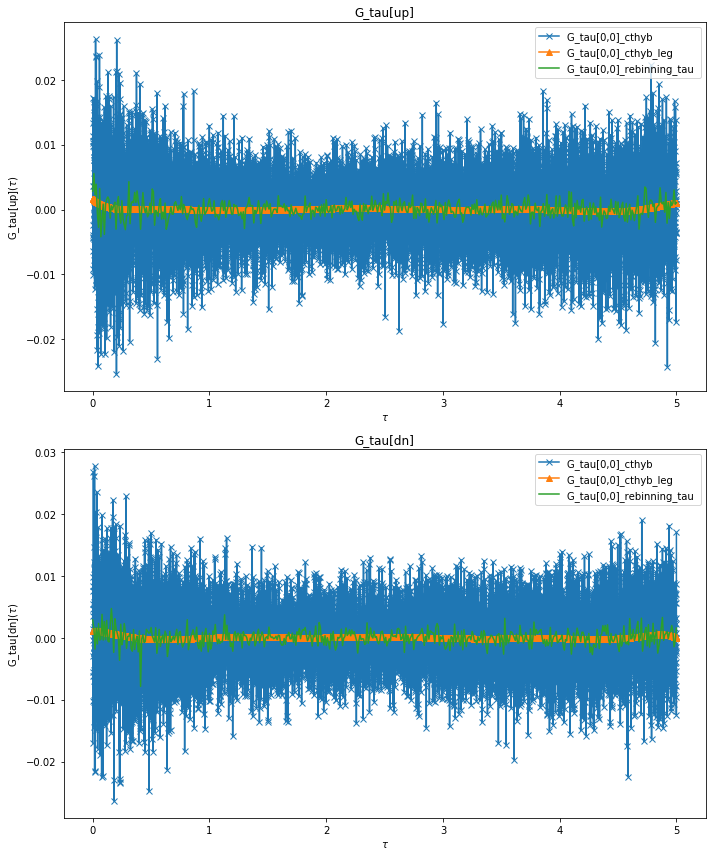

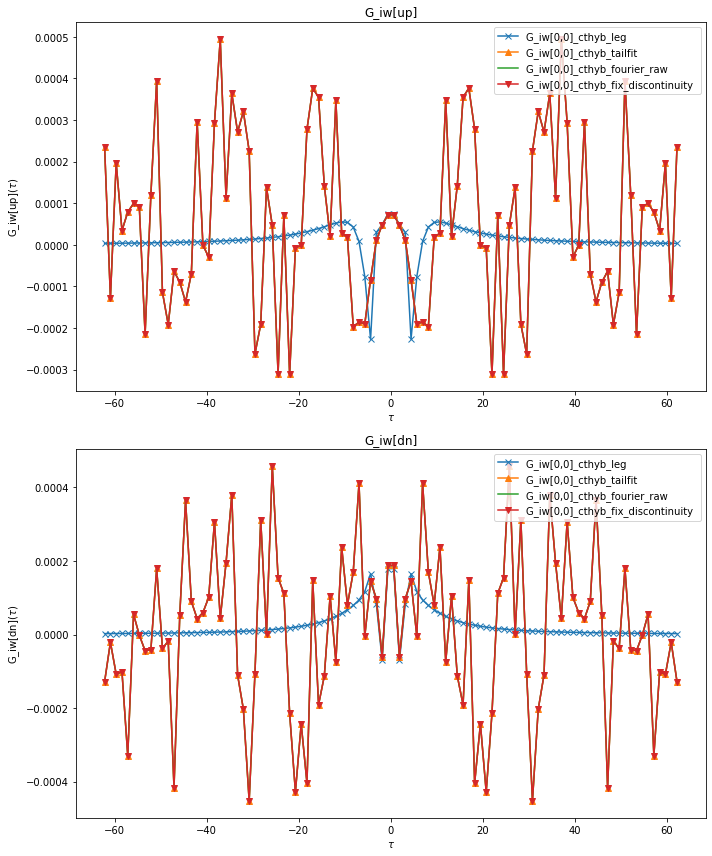

In [26]:
# %load ../common/plot.py
import sys, os
sys.path.append(os.getcwd() + "/..")
sys.path.append(os.getcwd() + "/../../common")
from model import *

from h5 import HDFArchive
from triqs.plot.mpl_interface import oplot, plt
from glob import glob
from os.path import basename

# === Load Green function for every solver and calculate self-energy

marker_lst = ['-x', '-^', '-', '-v', '-<', '->', '-*', '-p']
G_tau, G_iw = {}, {}

with HDFArchive('results/cthyb.h5','r') as dat:
    G_tau['cthyb'] = dat['G_tau']
    G_tau['cthyb_leg'] = dat['G_tau_leg']
    
    G_iw['cthyb_leg'] = dat['G_iw_leg']
    G_iw['cthyb_tailfit'] = dat['G_iw_tailfit']
    G_iw['cthyb_fourier_raw'] = dat['G_iw_fourier_raw']
    G_iw['cthyb_fix_discontinuity'] = dat['G_iw_fix_discontinuity']
    
G_exact = {}
with HDFArchive('results/atomdiag.h5','r') as dat:
    G_exact['G_tau'] = dat['G_tau']
    
    G_exact['G_iw'] = dat['G_iw']

# === For every block and solver, plot Green function

block_lst = list(G_tau['cthyb'].indices)
n_blocks = len(block_lst)


print(n_tau)
for g, name in [[G_tau, 'G_tau'], [G_iw, 'G_iw']]:

    plt.subplots(n_blocks,1,figsize=(10,6*n_blocks))

    for i, block in enumerate(block_lst,1):
        fig = plt.subplot(n_blocks,1,i)
        fig.set_title(name + "[" + block + "]")
        for marker_idx, solver in enumerate(list(g.keys())):
            marker = marker_lst[marker_idx]
            oplot(g[solver][block][0,0].real - G_exact[name][block][0,0].real, marker, name = name + "[0,0]_%s" % solver)
        if name == 'G_tau':
            n_tau_rebinning = 501
            G_rebinned = g['cthyb'][block].rebinning_tau(n_tau_rebinning)
            G_rebinned.data[:] -= G_exact[name][block].data[::(n_tau - 1) // (n_tau_rebinning - 1)]
            oplot(G_rebinned[0,0].real, '-', name = name + "[0,0]_rebinning_tau")
        plt.xlabel(r"$\tau$")
        plt.ylabel(name + "[" + block + r"]$(\tau)$")

    plt.tight_layout()
    plt.show()


Deviations
======

We present a table containing deviations between the different solvers measured via

$$||G_{\rm Solver_1} - G_{\rm Solver_2}||_\infty$$

In [27]:
import numpy as np

for g, name in [[G_tau, 'G_tau'], [G_iw, 'G_iw']]:
    for block in block_lst:
        solver_lst = list(g.keys())
        deviations = [[ np.amax(np.abs(g[s1][block].data - g[s2][block].data)) for s1 in solver_lst ] \
                        for s2 in solver_lst ]
        
        print("\t\t    Deviations for " + name + " Block " + block)
        print("\t\t -----------------------------------")
    
        row_format ="{:>15}" * (len(solver_lst) + 1)
        print(row_format.format("", *solver_lst))
        row_format ="{:>15}" + "{:>15.2E}" * len(solver_lst)
        for solver, row in zip(solver_lst, deviations):
            print(row_format.format(solver, *row))
            
        print("\n\n")

		    Deviations for G_tau Block up
		 -----------------------------------
                         cthyb      cthyb_leg
          cthyb       0.00E+00       3.11E-02
      cthyb_leg       3.11E-02       0.00E+00



		    Deviations for G_tau Block dn
		 -----------------------------------
                         cthyb      cthyb_leg
          cthyb       0.00E+00       2.98E-02
      cthyb_leg       2.98E-02       0.00E+00



		    Deviations for G_iw Block up
		 -----------------------------------
                     cthyb_leg  cthyb_tailfitcthyb_fourier_rawcthyb_fix_discontinuity
      cthyb_leg       0.00E+00       5.69E-04       5.69E-04       5.68E-04
  cthyb_tailfit       5.69E-04       0.00E+00       0.00E+00       1.30E-06
cthyb_fourier_raw       5.69E-04       0.00E+00       0.00E+00       1.30E-06
cthyb_fix_discontinuity       5.68E-04       1.30E-06       1.30E-06       0.00E+00



		    Deviations for G_iw Block dn
		 -----------------------------------
                 